# **Practical session n°1**

Notions:
- Training a perceptron through stochastic gradient descent.
- Multi-layer perceptron.
- Negative log-likelihood.

Duration: 2 h

This practical introduces neural networks through a presentation of the perceptron. It is also an opportunity to familiarize yourself with PyTorch commands (PyTorch is the most widely used libraries for deep learning).

The basic building blocks that allow us to construct these layers are coded in the torch.nn module.

In [70]:
from matplotlib import pyplot as plt
from IPython.display import clear_output, display
import numpy as np
import torch
import torch.nn as nn
torch.manual_seed(1)

## **1. A simple binary classification problem**

First, let's revisit the perceptron. To introduce learning through stochastic gradient descent, we will address a simple binary classification problem.

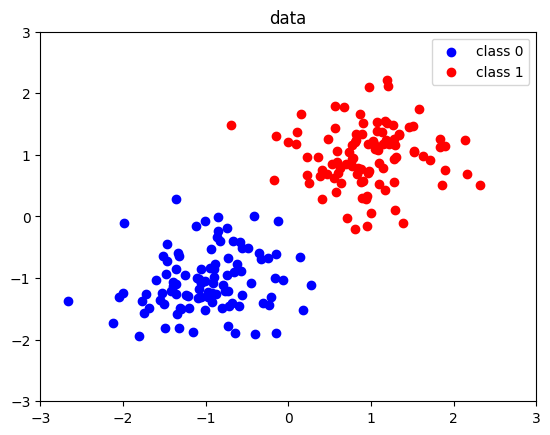

In [71]:


def BinaryClassProblem(n=100, std=0.5, manual_seed=1,
                       colors=['b', 'r'], labels=['class 0', 'class 1']):
  torch.manual_seed(manual_seed)
  # Data to separate:
  n = 100
  std = 0.5

  # Sample 1:
  mean0 = torch.tensor([-1., -1.])
  ech0 = mean0 + std * torch.randn(n, 2)

  # Sample 2:
  mean1 = torch.tensor([1., 1.])
  ech1 = mean1 + std * torch.randn(n, 2)

  echs = [ech0, ech1]

  # Scatter plot:
  fig, ax = plt.subplots()
  ax.axis([-3, 3, -3, 3])

  plt.title('data')
  for i, ech in enumerate(echs):
      x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
      ax.scatter(x, y, color=colors[i])

  plt.legend(labels)
  return echs, ax

n=100
colors = ['b', 'r']
labels = ['class 0', 'class 1']
echs, ax = BinaryClassProblem(n, colors=colors, labels=labels)

## **2. A simple perceptron**

A simple perceptron (single neuron) consists of two parts: a linear part containing a dot product and a "bias" (b) and a non-linear part, the activation function (A):
\begin{equation*}
 f(x; \omega,b) = \mathcal{A}({\sum} \omega_i x_i  + b )  \tag{1}
\end{equation*}

The class P1 below codes for perceptrons defined on $\mathbb{R}^2$ and whose activation function is a sigmoid:
\begin{equation*}
\mathcal{A}(y) = \dfrac{1}{1+e^{-y}}
\end{equation*}
The sigmoid function is in the range [0, 1]. Therefore, the neuron's output can be interpreted as the probability of belonging to the first of the two classes. In the P1 class, the neuron actually returns a vector of "probabilities":

In [72]:
class P1(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        # Dot product and bias
        x = self.fc(x)
        # Activation
        x = x.sigmoid()
        # Vector of "probabilities" (cat: concatenation)
        x = torch.cat((x, 1 - x), dim=1)
        return x


In the next cell, basic commands are given to :
- define an instance of P1
- apply it on a 2D torch.tensor
- access the weights (or "parameters") of model

In [73]:
model = P1()

# Apply model on a 2D tensor:
inputs = torch.tensor([[0.,1.]])
print(f'example of output: {model(inputs)}')

# Setting weights:
model.fc.weight[0, 0].data.fill_(-0.1)
model.fc.weight[0, 1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

# Retrieving weights:
fc = model.fc
weights = fc.weight.data.squeeze(dim=0)
bias = fc.bias.data

print(f'weights: {weights}')
print(f'bias: {bias}')

example of output: tensor([[0.6126, 0.3874]], grad_fn=<CatBackward0>)
weights: tensor([-0.1000,  0.5000])
bias: tensor([-1.])


**Exercise 1**:
- For the given set of parameters ($\omega_0 = -0.1$, $\omega_1 = 0.5$, and $b = -1$), find an input that produces an output of ($0.5$, $0.5$). Verify it in a single line of code.
- For any given input, find parameters that will produce an output of ($0.5$, $0.5$). Check it.  


In [74]:
# YOUR CODE HERE
#
inputs_test = torch.tensor([[-5., 1.]])
print(f'example of output: {model(inputs_test)}')

model_test = P1()

# Setting weights:
model_test.fc.weight[0, 0].data.fill_(0)
model_test.fc.weight[0, 1].data.fill_(0)
model_test.fc.bias.data.fill_(0)

print(model_test.fc.weight)
print(model_test.fc.weight[0, 1].data)
print(model_test.fc.bias.data)

inputs_rnd = torch.randn(1, 2)
print(f'random input: {inputs_rnd}')
print(f'output of second model: {model_test(inputs_rnd)}')

example of output: tensor([[0.5000, 0.5000]], grad_fn=<CatBackward0>)
Parameter containing:
tensor([[0., 0.]], requires_grad=True)
tensor(0.)
tensor([0.])
random input: tensor([[ 0.1085, -1.9447]])
output of second model: tensor([[0.5000, 0.5000]], grad_fn=<CatBackward0>)


To complete the definition of our classifier, a decision rule is needed. This rule is natural: for $f(x; \omega, b) = (p_0, p_1)$, we choose class 0 if $p_0 > p_1$.

**Exercise 2:**
When the input space is 2D, the boundary that delimits the classifier decision regions could be drawn. Complete the code below to plot it.

/tmp/ipython-input-2860885711.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x1 = (-bias - weights[0] * x0) / weights[1]


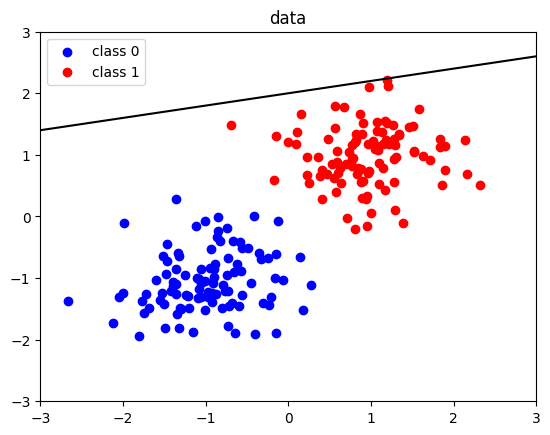

In [75]:
def drawDecisionBoundary(model, ax, interval=[-10, 10], color='black'):
    x0 = np.arange(interval[0], interval[1], 0.01)
    # YOUR CODE HERE
    #
    weights = model.fc.weight.data.squeeze(dim=0)
    bias = model.fc.bias.data
    x1 = (-bias - weights[0] * x0) / weights[1]
    ax.plot(x0, x1, color=color)


echs, ax = BinaryClassProblem()
drawDecisionBoundary(model, ax)
plt.show()


## **3. Dataset and Dataloader**

To train the perceptron to correctly separate the classes, we will use stochastic gradient descent with mini-batches. For this, we need to present the model with (*input*, *target*) pairs in a **random** order. In PyTorch, this selection is done using two objects:
- A *Dataset* class
- A *Dataloader* class

A PyTorch **Dataset** contains a method for accessing data. The following class provides a rudimentary example. Later on, we will integrate data loading, normalization, and data augmentation steps into our datasets:

In [76]:
from torch.utils.data import Dataset, DataLoader
class FirstDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):  # idx is an index called by the loader
        x = self.inputs[idx, :]
        t = self.targets[idx]
        return x, t  # (input, target) pair

inputs_train = torch.cat(echs, dim=0)
targets_train = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()
ds1 = FirstDataset(inputs_train, targets_train)

A **loader** is a Python iterable (like lists, dictionaries, etc.) that we parameterize by batch size and data selection method (with or without replacement, weighting, etc). In particular, with the *shuffle=True* option, the data is reshuffled at every epoch.

The option *num_workers* represents how many subprocesses to use for data loading, 0 means that the data will be loaded in the main process (generally interesting to anticipate data loading, to speed up training).

In [77]:
loader1 = DataLoader(ds1, batch_size=10, shuffle=False, num_workers=0)

In the following figure, we represent a first randomly drawn batch of points. Each time the window is executed, a new batch of points is drawn until exhaustion:

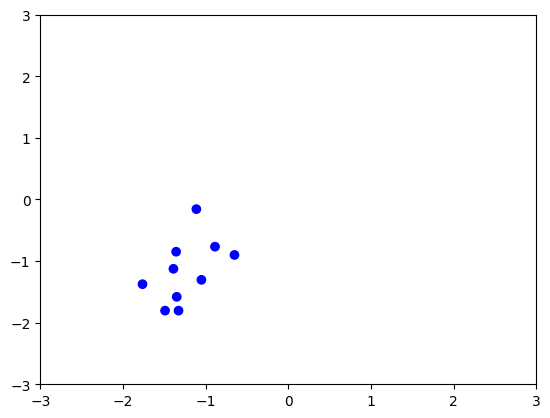

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis([-3, 3, -3, 3])

# Drawing a batch of ten points
inputs, targets = next(iter(loader1))
x, y = inputs.numpy()[:, 0], inputs.numpy()[:, 1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax.scatter(x, y, color=cs)

**Exercise 3**: \
Plot the successive batches along one epoch.

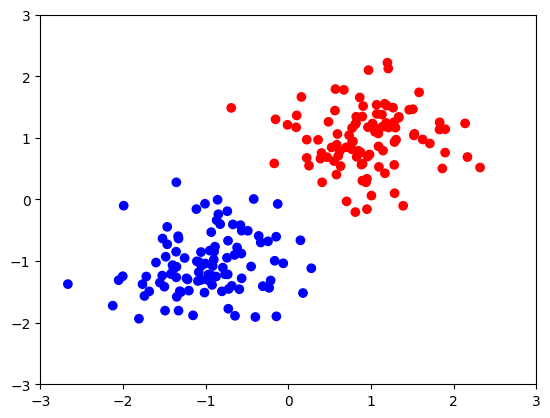

In [79]:
from IPython.display import clear_output, display
import time
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set(xlim=(-3, 3), ylim=(-3, 3))

for inputs, targets in loader1: # YOUR CODE HERE # :

    # YOUR CODE HERE #
    x, y = inputs.numpy()[:, 0], inputs.numpy()[:, 1]
    cs = [colors[targets[i]] for i in range(len(targets))]
    ax.scatter(x, y, color=cs)
    display(fig)
    time.sleep(0.5)
    clear_output(wait=True)


## **4. A Loss function for Classification. Updating the weights.**

For each available batch, we calculate the model's error using a loss function. This loss function penalizes the differences between the network's outputs (here, pairs $(p_0, p_1)$) and the ground truth (here, a class $c \in \{ 0 ; 1 \}$).

In classification, we generally use the **negative log likelihood**. For a batch point, it is defined as:

$\mathcal{L}((p_0, p_1), c) = - ln(p_c)$

This quantity is averaged over each batch:

In [80]:
def loss_fn(outputs, targets, show=False):
    # all -log(p)
    outputs = -torch.log(outputs)
    # all -log(pc)
    tensor_of_losses = torch.gather(outputs, 1, targets.unsqueeze(dim=1))
    # average of -log(pc)
    loss = tensor_of_losses.mean()

    if show:
        print(outputs)
        print(targets)
        print(tensor_of_losses)

    return loss

Example:

In [81]:
inputs, targets = next(iter(loader1))
outputs = model(inputs)
l = loss_fn(outputs, targets, show=True)

print(l)

tensor([[1.7106, 0.1994],
        [1.9270, 0.1573],
        [1.7402, 0.1930],
        [1.9130, 0.1597],
        [1.5320, 0.2435],
        [1.6397, 0.2157],
        [1.2893, 0.3222],
        [1.5367, 0.2422],
        [1.8302, 0.1748],
        [1.6086, 0.2234]], grad_fn=<NegBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[1.7106],
        [1.9270],
        [1.7402],
        [1.9130],
        [1.5320],
        [1.6397],
        [1.2893],
        [1.5367],
        [1.8302],
        [1.6086]], grad_fn=<GatherBackward0>)
tensor(1.6727, grad_fn=<MeanBackward0>)


For each batch, we calculate the derivatives $\dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$ where $\mathcal{L_{batch}}$ is the average of the cost function over the batch.

PyTorch keeps track of each operation performed with the weights so that it can apply the usual rules of derivation. This calculation is launched with the *backward* method. The derivatives are stored with the weights and can be accessed with *.grad*:

In [82]:
w = model.fc.weight  # [0,0]
print('before backward:' + str(w.grad))
print(w[0])

l.backward()
print('after backward:' + str(w.grad))

before backward:None
tensor([-0.1000,  0.5000], grad_fn=<SelectBackward0>)
after backward:tensor([[1.0049, 0.9616]])


In [83]:
print(w[0, 0])

tensor(-0.1000, grad_fn=<SelectBackward0>)


Last step: updating the weights. For this, many methods are available. We specify the chosen method through the PyTorch "optimizer" object. The simplest is written:

$w_i := w_i - lr \times \dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$  (2)

The learning rate ($lr$) controls the amplitude of the increments:

In [84]:
lr = 0.1
# Two commonly used descent methods:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # corresponds to equation (2)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In the next cell, we train the perceptron. With each new execution, the dataset is traversed twice (two "epochs"):

0
1
2
3
4


/tmp/ipython-input-2860885711.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x1 = (-bias - weights[0] * x0) / weights[1]


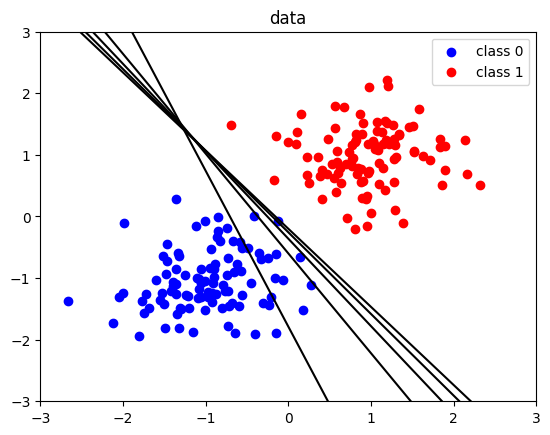

In [85]:
_, ax = BinaryClassProblem()

for epoch in range(5):
    print(epoch)
    # random traversal of the dataset
    for x, targets in loader1:
        # zeroing gradients
        optimizer.zero_grad()
        # calculation of (p0, p1)
        output = model(x)
        # calculation of the error
        l = loss_fn(output, targets)
        # calculation of gradients
        l.backward()
        # weight update
        optimizer.step()

    # Plotting the hyperplane
    drawDecisionBoundary(model, ax)

**Exercise 4**: Complete the following code to plot the gradients in the $\omega_0, \omega_1$ weight space:

tensor([[0.0551, 0.0728]])
tensor([[0.0447, 0.0816]])
tensor([[0.0476, 0.0553]])
tensor([[0.0437, 0.0607]])
tensor([[0.0441, 0.0513]])
tensor([[0.0116, 0.0725]])
tensor([[0.0433, 0.0309]])
tensor([[0.0578, 0.0323]])
tensor([[0.0280, 0.0407]])
tensor([[0.0363, 0.0415]])
tensor([[0.0139, 0.0738]])
tensor([[0.0503, 0.0300]])
tensor([[0.0487, 0.0301]])
tensor([[0.0453, 0.0335]])
tensor([[0.0361, 0.0221]])
tensor([[0.0272, 0.0370]])
tensor([[0.0432, 0.0324]])
tensor([[0.0223, 0.0320]])
tensor([[0.0217, 0.0291]])
tensor([[0.0142, 0.0409]])


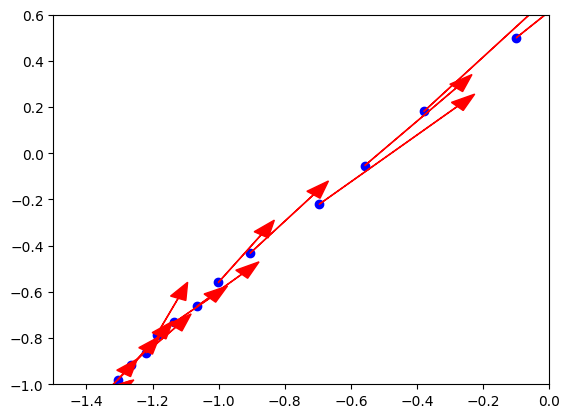

In [86]:
# Initialization of weights:
model.fc.weight[0, 0].data.fill_(-0.1)
model.fc.weight[0, 1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.axis([-1.5, 0, -1, 0.6])

loader1 = DataLoader(ds1, batch_size=10, shuffle=True)
lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(25):
    for x, label in loader1:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()

        # weights = ...
        # YOUR CODE HERE
        w0 = model.fc.weight[0, 0].data
        w1 = model.fc.weight[0, 1].data

        # gradients:
        # gradient = ...
        gradient = model.fc.weight.grad

        # ax3.scatter(...)
        # ax3.arrow(...)
        ax3.scatter(w0, w1, color='blue')
        ax3.arrow(w0, w1, gradient[0, 0], gradient[0, 1], color='red', head_width=0.05)
        if epoch == 1:
          print(gradient)

        optimizer.step()

## **5. Scoring a classification model with accuracy.**

Scoring a model is an essential step. In the following exercise, we present a very simple score, accuracy, which consists of counting the proportion of correctly assigned classes. It is calculated on the training set and on an independent set, the **test set**.

**Exercise 5:**
- With the help of the torch.max function, determine the accuracy of the classifier on the **training set**.
- Sample an independant **test set** and compute the accuracy on it.

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
Accuracy train:100.00%
Accuracy test:99.50%


/tmp/ipython-input-2860885711.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x1 = (-bias - weights[0] * x0) / weights[1]


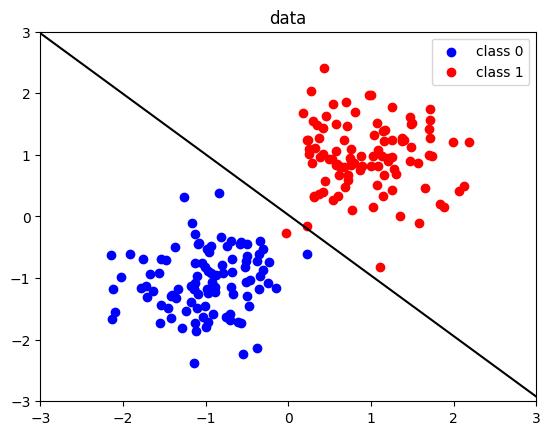

In [87]:
model.eval()
### YOUR CODE HERE
#
#
inputs_train = torch.cat(echs, dim=0)
targets_train = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()
echs_test, ax = BinaryClassProblem(n=100, std=0.5, manual_seed=10)
inputs_test = torch.cat(echs_test, dim=0)
targets_test = torch.cat((torch.zeros(n), torch.ones(n)), dim=0).long()

indices = torch.max(model(inputs_train), dim=1)
print(indices[1])
hits = indices[1] == targets_train
acc = hits.sum().float() / (2 * n)*100

print(f"Accuracy train:{acc:.2f}%")


hits = torch.max(model(inputs_test), dim=1)[1] == targets_test
acc = hits.sum().float() / (2 * n)*100
print(f"Accuracy test:{acc:.2f}%")
drawDecisionBoundary(model, ax)



**Note:**

A model of the class *P1* corresponds to a class of statistical models widely used with predictors of small dimensions: logistic regression.

This model is used to **explain and predict** the value of a binary qualitative variable.

Let Z be a random variable with values in $\{c_1, c_2\}$.
Logistic regression with respect to the predictor $X = (X_1, X_2, ...)$ is written:

$$ ℙ(Z = c_1 | X ) = \sigma (\sum \omega_i X_i + b ) $$

Where $\sigma$ is the sigmoid function. However, in the context of logistic regression, the weights $\omega_i$ are obtained by **maximum likelihood**.



## **I.6. A more complex binary classification problem**

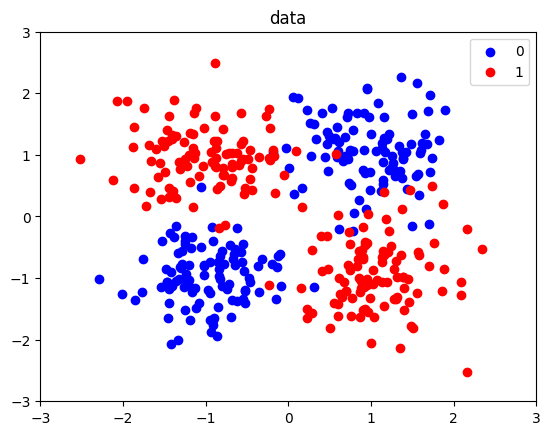

In [88]:
# The XOR problem

n = 100
std = 0.5
# sample 0:
meana = torch.tensor((-1., -1.))
echa = meana + std * torch.randn(n, 2)
meanb = torch.tensor((1., 1.))
echb = meanb + std * torch.randn(n, 2)

ech0 = torch.cat([echa, echb])

# sample :
meanc = torch.tensor((1., -1.))
echc = meanc + std * torch.randn(n, 2)
meand = torch.tensor((-1., 1.))
echd = meand + std * torch.randn(n, 2)

ech1 = torch.cat([echc, echd])

echs2 = [ech0, ech1]

# Scatter plot:

plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r']
labels = ['0', '1']

for i, ech in enumerate(echs2):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    plt.scatter(x, y, color=colors[i])

plt.legend(labels)

**Exercise 6:**

- What is the approximate best accuracy achievable with a model of class *P1*?

- Complete the *P3* class and train a model to achieve an accuracy of at least 90% on the training set.

- Why does the score after 50 epochs vary so much with each new training?

- Is it possible, with another class of model, to achieve 100% accuracy?

In [104]:
class P3(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)  # first layer: 2 neurons
        self.fc2 = nn.Linear(2, 1)  # second layer: 1 neuron

    def forward(self, x):
        x = self.fc1(x)
        ### YOUR CODE HERE
        #
        #
        x = x.relu()
        x = self.fc2(x)
        x = x.sigmoid()

        x = torch.cat((x, 1 - x), dim=1)  # output of sum 1
        return x

In [105]:
# dataset
### YOUR CODE HERE
#
#

inputs2 = torch.cat(echs2, dim=0)
targets2 = torch.cat((torch.zeros(2 * n), torch.ones(2 * n)), dim=0).long()
ds2 = FirstDataset(inputs2, targets2)
### END SOLUTION
loader2 = DataLoader(ds2, batch_size=10, shuffle=True,num_workers=0)


In [109]:
from tqdm import tqdm # Progess bar
lr = 0.1
model = P3()
# Two commonly used descent methods:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(100)):
    for x, labels in loader2:
        ### YOUR CODE HERE
        #
        #
        #
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, labels)
        l.backward()
        optimizer.step()


print("\nTraining end")
# accuracy
### YOUR CODE HERE
#
outputs2 = model(inputs2)
argmax = torch.max(outputs2, dim=1)[1]
hits = argmax == targets2
acc = hits.sum().float() / (4 * n)*100
print(f"Accuracy:{acc:.2f}%")


100%|██████████| 100/100 [00:03<00:00, 33.27it/s]


Training end
Accuracy:90.00%


In [113]:
class P9(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4) # a first layer with 4 neurons
        self.fc2 = nn.Linear(4,4) # a second layer with 4 neurons
        self.fc3 = nn.Linear(4,1) # a third layer with 1 neuron
    ### YOUR CODE HERE
    def forward(self, x):
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        x = self.fc3(x)
        x = x.sigmoid()
        return torch.cat((x, 1-x), dim=1)
    ### END SOLUTION

In [122]:
model = P9()
### BEGIN SOLUTION
loader2 = DataLoader(ds2,batch_size = 64, shuffle = True, num_workers = 0)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for epoch in tqdm(range(200)):
    for x, labels in loader2:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, labels)
        l.backward()
        optimizer.step()

print("\nTraining end")

### END SOLUTION
hits = torch.max(model(inputs2), dim=1)[1] == targets2
acc = hits.sum().float() / (4 * n)*100

print(f"Accuracy:{acc:.2f}%")

100%|██████████| 200/200 [00:01<00:00, 124.97it/s]


Training end
Accuracy:95.00%


As the complexity of the model increases, the boundaries can better adapt to the **training set**.

## **I.7. A multi-class classification problem**

Now let's see how to generalize the approach to multiple classes:

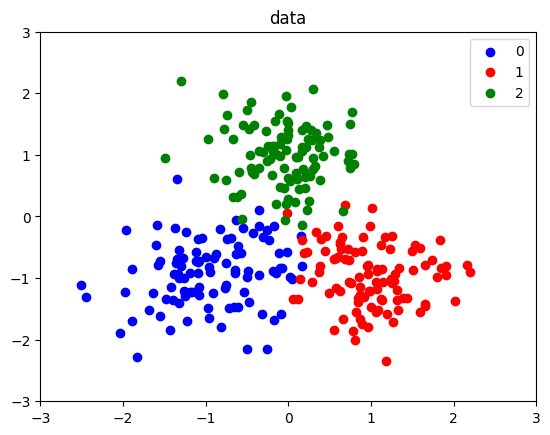

In [123]:
n = 100
std = 0.5
# Sample 0:
mean0 = torch.tensor((-1., -1.))
ech0 = mean0 + std * torch.randn(n, 2)

# Sample 1:
mean1 = torch.tensor((1., -1.))
ech1 = mean1 + std * torch.randn(n, 2)

# Sample 2:
mean2 = torch.tensor((0., 1.))
ech2 = mean2 + std * torch.randn(n, 2)

echs3 = [ech0, ech1, ech2]

# Scatter plot:
plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b', 'r', 'g']
labels = ['0', '1', '2']

for i, ech in enumerate(echs3):
    x, y = ech.numpy()[:, 0], ech.numpy()[:, 1]
    plt.scatter(x, y, color=colors[i])

plt.legend(labels)

To separate these points, we need to slightly modify the perceptron. To continue using the log-likelihood, the output layer will have as many neurons as classes. Additionally, to define a probability distribution, normalized exponentials are used (softmax function):

$p_i = \dfrac{e^{y_i}}{\sum{e^{y_j}}}$
  
Where the $y_i$ are the outputs of the neurons in the last layer.

In [124]:
class P6(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)  # First layer: 2 neurons
        self.fc2 = nn.Linear(2, 3)  # Second layer: 3 neurons

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.softmax(dim=1)
        return x

**Exercise 7:** Create datasets and dataloaders objects and check if it is possible to separate the points (test accuracy > 90%).

In [126]:
### YOUR CODE HERE
#
#
inputs3 = torch.cat(echs3, dim=0)
targets3 = torch.cat((torch.zeros(n), torch.ones(n), 2 * torch.ones(n)), dim=0).long()
ds3 = FirstDataset(inputs3, targets3)

In [132]:
model = P6()
### BEGIN SOLUTION
#
#
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loader3 = DataLoader(ds3, batch_size=10, shuffle=True, num_workers=0)

for epoch in tqdm(range(100)):
    for x, labels in loader3:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, labels)
        l.backward()
        optimizer.step()

print("\nTraining end")

### END SOLUTION
hits = torch.max(model(inputs3), dim=1)[1] == targets3
acc = hits.sum().float() / (3 * n)*100

print(f"Accuracy:{acc:.2f}%")

100%|██████████| 100/100 [00:01<00:00, 55.03it/s]


Training end
Accuracy:97.67%
